In [208]:
import tskit
import matplotlib.pyplot as plt
import sparg
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.gridspec as grid_spec
import math

In [209]:
ts = tskit.load("rep0_S025_I1_R2_W100_D2_with_migration.trees")

In [210]:
np.random.seed(0)
num_samples = 40
samples = list(np.random.choice(ts.samples(), num_samples, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)

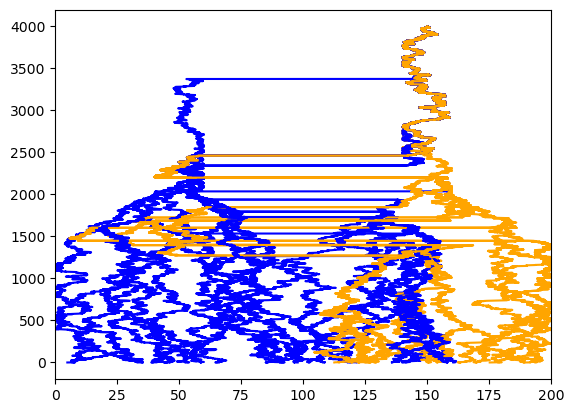

In [211]:
blue = 0
for i in range(num_samples):
    path = [i] + list(sparg.ancestors(ts_sim.first(), i))
    times = []
    locations = []
    for node in path:
        times.append(ts_sim.node(node).time)
        indiv = ts_sim.node(node).individual
        if indiv != -1:
            locations.append(ts_sim.individual(indiv).location[0])
    if locations[2000] < 100:
        blue += 1
        plt.plot(locations, times, color="blue")
    else:
        plt.plot(locations, times, color="orange")
plt.xlim(0,200)
plt.show()

In [216]:
from scipy.optimize import minimize

def prob_coal_time(t, deme0, deme1, M, n=2):
    """Calculates the probability of a coalescence time given the starting demes

    Equations from Wilkinson-Herbots (2008)

    Parameters
    ----------
    t : float
        time of coalescent event
    deme0 : int
        id of starting deme for lineage 0
    deme1 : int
        id of starting deme for lineage 1
    M : float
        migration rate
    n : int
        number of demes. (default: 2)

    Returns
    -------
    probability density for the time given the starting parameters
    
    """

    D = (n*M+n-1)**2-4*(n-1)*M
    l1 = (n*M+n-1-math.sqrt(D))/(2*(n-1))
    l2 = (n*M+n-1+math.sqrt(D))/(2*(n-1))
    f_X1 = l1*math.exp(-l1*t)
    f_X2 = l2*math.exp(-l2*t)
    if deme0 == deme1:
        A01 = (l2-1)/(l2-l1)
        A02 = (1-l1)/(l2-l1)
        return A01*f_X1 + A02*f_X2
    A11 = (l2)/(l2-l1)
    A12 = (-l1)/(l2-l1)
    return A11*f_X1 + A12*f_X2

def calc_prob_of_tree(parameter_vector, ts):
    cutoff = parameter_vector[0]
    boundary = parameter_vector[1]
    migration_rate = parameter_vector[2]
    
    parents = ts.tables.edges.parent
    keep_nodes = []
    for node in ts.nodes():
        if node.is_sample() or (node.time==cutoff) or (len(np.where(parents==node.id)[0])>1):
            keep_nodes.append(node.id)
    ts_cutoff, maps_cutoff = ts.simplify(samples=keep_nodes, update_sample_flags=False, map_nodes=True)
    print(ts_cutoff.draw_text())
    ts_chopped = sparg.chop_arg(ts_cutoff, cutoff)
    spatial_arg = sparg.SpatialARG(ts=ts_chopped)
    samples = []
    genome_positions = []
    times = []
    locations = []
    for sample in spatial_arg.ts.samples():
        samples.append(sample)
        genome_positions.append(0)
        times.append(cutoff)
        ancestor = sparg.find_ancestral_node_at_time(spatial_arg.ts.first(), sample, cutoff)
        indiv = spatial_arg.ts.node(ancestor).individual
        if indiv != -1:
            locations.append(spatial_arg.ts.individual(indiv).location[0])
        else:
            locations.append([None for d in range(1)])
    df = pd.DataFrame({
        "sample":samples,
        "genome_position":genome_positions,
        "time":times,
        "true_location":locations
    })
    roots = sparg.estimate_locations_of_ancestors_in_dataframe_using_arg(
        df=df,
        spatial_arg=spatial_arg
    )
    roots["prob_left"] = norm.cdf(boundary, roots["arg_estimated_location_0"], np.sqrt(roots["arg_variance_in_estimated_location_0"]))
    
    node_ids = []
    for sample in roots["sample"]:
        node_ids.append(sparg.find_ancestral_node_at_time(spatial_arg.ts.first(), sample, cutoff))
    roots["id"] = node_ids

    sorted_roots = roots.sort_values(by=["arg_estimated_location_0"], ascending=True)
    sorted_roots = sorted_roots.drop_duplicates("arg_estimated_location_0").reset_index()

    approx_log_prob = 0
    for s,root0 in sorted_roots.iterrows():
        for r,root1 in sorted_roots.iterrows():
            if r > s:
                cond_prob_of_c = 0
                for i in [0,1]:
                    if i == 0:
                        prob_of_i_loc = root0["prob_left"]
                    else:
                        prob_of_i_loc = 1 - root0["prob_left"]
                    for j in [0,1]:
                        if j == 0:
                            prob_of_j_loc = root1["prob_left"]
                        else:
                            prob_of_j_loc = 1 - root1["prob_left"]
                        cond_prob_of_c += prob_of_i_loc * prob_of_j_loc * prob_coal_time(ts_cutoff.first().tmrca(int(root0.id), int(root1.id)), i, j, migration_rate)
                approx_log_prob += np.log(cond_prob_of_c)
    print(parameter_vector, approx_log_prob)
    return abs(approx_log_prob)


calc_prob_of_tree([2580, 200, 0.0007], ts_sim)
    
#minimize(
#    calc_prob_of_tree,
#    [1250, 200, 0.0001],
#    method="nelder-mead",
#    bounds=[(1000, 3000), (0, 400), (0, 0.001)],
#    args=(ts_sim)
#)

3394.00┊                                                                                       80                      ┊
       ┊                                                                   ┏━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━┓ ┊
2770.00┊                                                                  79                                         ┃ ┊
       ┊                                     ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓          ┃ ┊
2580.00┊                                    78                                                           76         77 ┊
       ┊                                     ┃                                                     ┏━━━━━━┻━━━━━━┓   ┃ ┊
2336.00┊                                    75                                                     ┃             ┃   ┃ ┊
       ┊                ┏━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━┓                                ┃             ┃   ┃ ┊
2129.00┊               74       

np.float64(50.232112377106034)

In [201]:



bs = []
ms = []
ps = []

maxs = -999999
bs_maxs = -999999
ms_maxs = -999999
ps_maxs = -999999

gap = 10
for boundary in range(0, 400+gap, gap):
    
    roots = sparg.estimate_locations_of_ancestors_in_dataframe_using_arg(
        df=df,
        spatial_arg=spatial_arg
    )
    roots["prob_left"] = norm.cdf(boundary, roots["arg_estimated_location_0"], np.sqrt(roots["arg_variance_in_estimated_location_0"]))
    
    node_ids = []
    for sample in roots["sample"]:
        node_ids.append(sparg.find_ancestral_node_at_time(spatial_arg.ts.first(), sample, cutoff))
    roots["id"] = node_ids

    sorted_roots = roots.sort_values(by=["arg_estimated_location_0"], ascending=True)
    sorted_roots = sorted_roots.drop_duplicates("arg_estimated_location_0").reset_index()

    maxs_mr = -999999
    bs_maxs_mr = -999999
    ms_maxs_mr = -999999
    ps_maxs_mr = -999999
    
    for mr in range(1, 50):
        approx_log_prob = 0
        for s,root0 in sorted_roots.iterrows():
            for r,root1 in sorted_roots.iterrows():
                if r > s:
                    cond_prob_of_c = 0
                    for i in [0,1]:
                        if i == 0:
                            prob_of_i_loc = root0["prob_left"]
                        else:
                            prob_of_i_loc = 1 - root0["prob_left"]
                        for j in [0,1]:
                            if j == 0:
                                prob_of_j_loc = root1["prob_left"]
                            else:
                                prob_of_j_loc = 1 - root1["prob_left"]
                            cond_prob_of_c += prob_of_i_loc * prob_of_j_loc * prob_coal_time(ts_cutoff.first().tmrca(int(root0.id), int(root1.id)), i, j, mr/10000)
                    #print(int(root0.id), int(root1.id), cond_prob_of_c)
                    approx_log_prob += np.log(cond_prob_of_c)

        if approx_log_prob > maxs_mr:
            bs_maxs_mr = boundary
            ms_maxs_mr = mr/10000
            ps_maxs_mr = approx_log_prob
            maxs_mr = approx_log_prob
        
        if approx_log_prob > maxs:
            bs_maxs = boundary
            ms_maxs = mr/10000
            ps_maxs = approx_log_prob
            maxs = approx_log_prob

        #print(boundary, mr/10000, approx_log_prob)
        
        bs.append(boundary)
        ms.append(mr/10000)
        ps.append(approx_log_prob)
        
    print(bs_maxs_mr, ms_maxs_mr, ps_maxs_mr)

0 0.0007 -6913.506974085548


KeyboardInterrupt: 

In [174]:
print(bs_maxs, ms_maxs, ps_maxs)

100 0.0004 -4925.660059400012


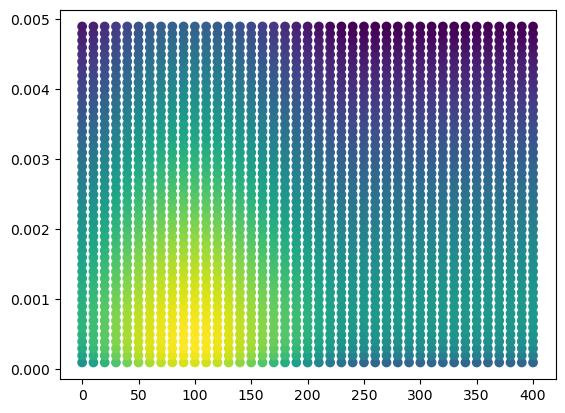

In [175]:
plt.scatter(bs, ms, c=ps)
plt.show()

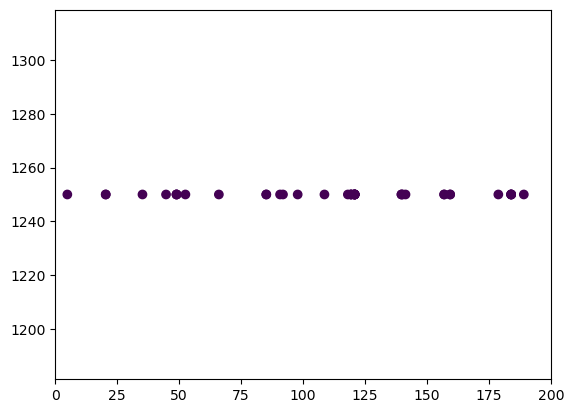

In [142]:
plt.scatter(roots["arg_estimated_location_0"], roots["time"], c=roots["prob_left"])
plt.xlim(0,200)
plt.show()

### Ridgeline Plot

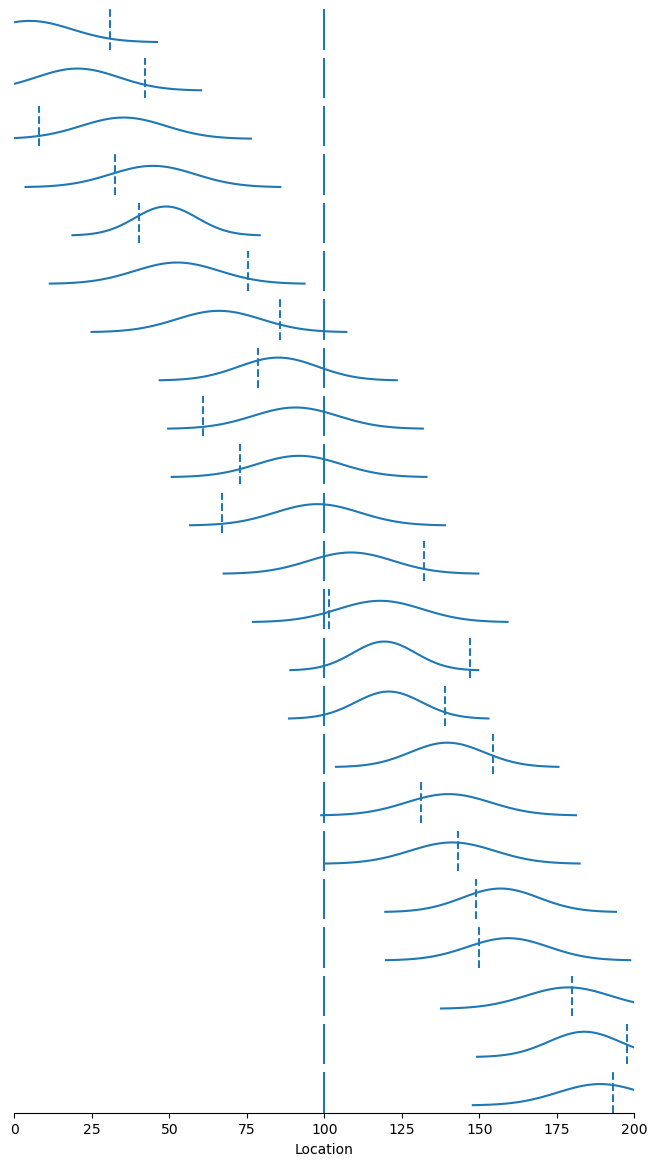

In [75]:
gs = (grid_spec.GridSpec(len(roots),1))

fig = plt.figure(figsize=(8,25))

#creating empty list
ax_objs = []

sorted_roots = roots.sort_values(by=["arg_estimated_location_0"], ascending=True)
sorted_roots = sorted_roots.drop_duplicates("arg_estimated_location_0").reset_index()

for i,root in sorted_roots.iterrows():
    # creating new axes object and appending to ax_objs
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    
    mu = root["arg_estimated_location_0"]
    sigma = np.sqrt(root["arg_variance_in_estimated_location_0"])
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax_objs[-1].plot(x, norm.pdf(x, mu, sigma))
    ax_objs[-1].axvline(root["true_location"], linestyle="dashed")
    ax_objs[-1].axvline(100)
    
    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0, 200)
    ax_objs[-1].set_ylim(-0.01,0.045)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticks([])

    if i == len(sorted_roots)-1:
        ax_objs[-1].set_xlabel("Location")
    else:
        ax_objs[-1].set_xticks([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        if i == len(sorted_roots)-1 and s == "bottom":
            pass
        else:
            ax_objs[-1].spines[s].set_visible(False)

#gs.update(hspace= -0.2)

#plt.savefig("images/ancestral_location_distributions.svg")
plt.show()